# Part 4: Тестируем модель FixEfficientNetB7 с базовыми настройками
- С теми же параметрами аугментации, что и в прошлом эксперименте.
- Пока без файн тюнинга, сначала разберемся самой моделью.

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf

# Конфигурируем GPU
# config = tf.compat.v1.ConfigProto(
#     gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7))
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)
# tf.compat.v1.keras.backend.set_session(session)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Numpy        : 1.19.4
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!pip freeze > requirements.txt

## Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

# EPOCHS = 5  # эпох на обучение
BATCH_SIZE = 32  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR = 0.001 # lerning rate
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 128  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

part = 'part_4'  # Версия эксперимента

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

### Необходимые функции

In [7]:
# Графики
def make_graf(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [8]:
# Тест модели
def start_learning(num_epochs):
    with tf.device('cpu:0'):
        history = model.fit_generator(
            train_generator,
            steps_per_epoch=len(train_generator),
            validation_data=test_generator,
            validation_steps=len(test_generator),
            epochs=num_epochs,
            callbacks=callbacks_list
        )

        return history

## EDA / Анализ данных

In [9]:
train_df = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [11]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

Пример картинок (random sample)


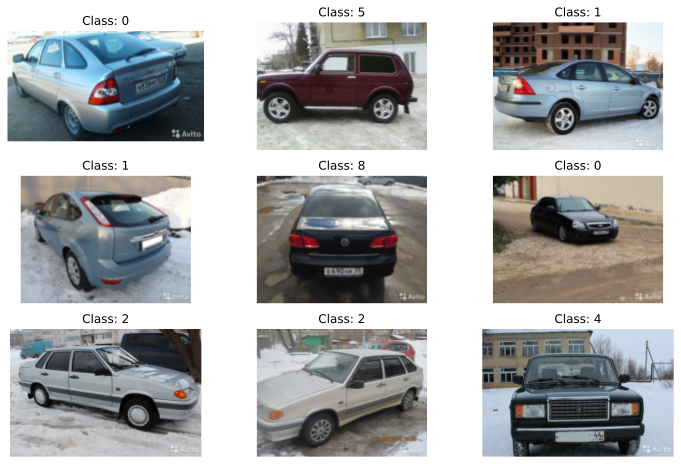

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(f'data/train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')

plt.show()

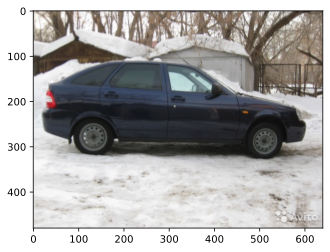

(640, 480)

In [13]:
image = PIL.Image.open('data/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
### Аугментация данных

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=VAL_SPLIT,  # set validation split
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1],
    zoom_range=0.1,
    channel_shift_range=1.0)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [15]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    'data/train/',      # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    'data/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory='data/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим результат

Пример картинок из train_generator


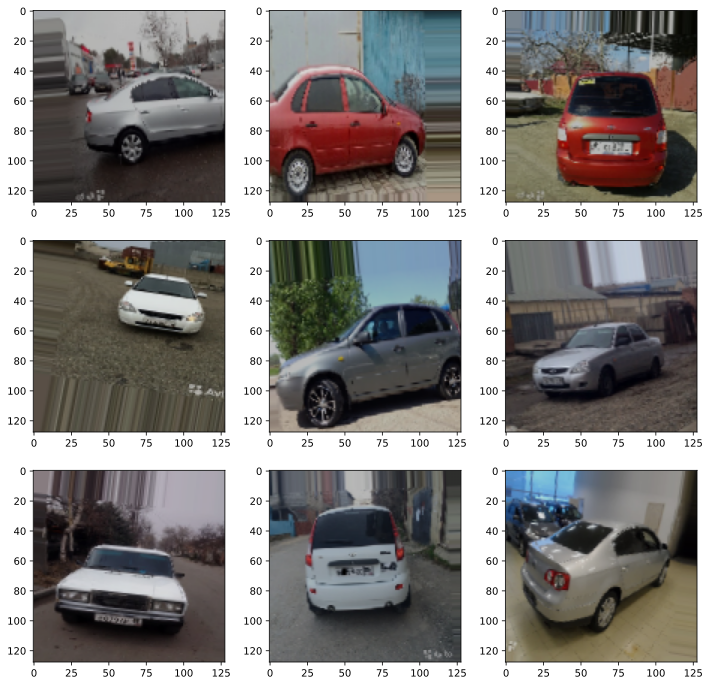

In [16]:
from skimage import io
 
def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()
 
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,12))
 
for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели
### Загружаем предобученную сеть FixEfficientNet-B7

In [17]:
base_model = efn.EfficientNetB7(
    weights='imagenet', include_top=False, input_shape=input_shape)

Строим модель

In [18]:
# Устанавливаем новую "голову" (head)
x = base_model.output

# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

# x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [19]:
model.summary()

                
__________________________________________________________________________________________________
block6l_expand_bn (BatchNormali (None, 4, 4, 2304)   9216        block6l_expand_conv[0][0]        
__________________________________________________________________________________________________
block6l_expand_activation (Acti (None, 4, 4, 2304)   0           block6l_expand_bn[0][0]          
__________________________________________________________________________________________________
block6l_dwconv (DepthwiseConv2D (None, 4, 4, 2304)   57600       block6l_expand_activation[0][0]  
__________________________________________________________________________________________________
block6l_bn (BatchNormalization) (None, 4, 4, 2304)   9216        block6l_dwconv[0][0]             
__________________________________________________________________________________________________
block6l_activation (Activation) (None, 4, 4, 2304)   0           block6l_bn[0][0]           

## Обучение модели
Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [20]:
checkpoint = ModelCheckpoint('best_model_{}.hdf5'.format(
    part), monitor=['val_accuracy'], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

### Обучаем

In [21]:
history = start_learning(5)

Epoch 1/5
414/414 [==============================] - 5381s 13s/step - loss: 1.8786 - accuracy: 0.3310 - val_loss: 1.0195 - val_accuracy: 0.6531

Epoch 00001: saving model to best_model_part_4.hdf5
Epoch 2/5
414/414 [==============================] - 5624s 14s/step - loss: 0.8357 - accuracy: 0.7073 - val_loss: 0.5239 - val_accuracy: 0.8064

Epoch 00002: saving model to best_model_part_4.hdf5
Epoch 3/5
414/414 [==============================] - 5590s 13s/step - loss: 0.5853 - accuracy: 0.7991 - val_loss: 0.3966 - val_accuracy: 0.8502

Epoch 00003: saving model to best_model_part_4.hdf5
Epoch 4/5
414/414 [==============================] - 5509s 13s/step - loss: 0.4692 - accuracy: 0.8324 - val_loss: 0.3754 - val_accuracy: 0.8729

Epoch 00004: saving model to best_model_part_4.hdf5
Epoch 5/5
414/414 [==============================] - 5280s 13s/step - loss: 0.3941 - accuracy: 0.8543 - val_loss: 0.4309 - val_accuracy: 0.8480

Epoch 00005: saving model to best_model_part_4.hdf5


In [22]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last_{}.h5'.format(part))
model.load_weights('best_model_{}.hdf5'.format(part))

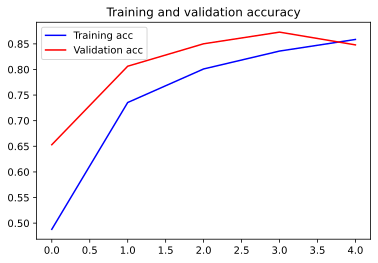

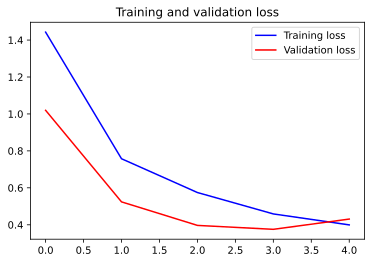

In [23]:
# Графики
make_graf(history)

### Оценим метрику

In [22]:
with tf.device('cpu:0'):
    scores = model.evaluate_generator(
        test_generator, steps=len(test_generator), verbose=1)

print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 147s 2s/step - loss: 0.4447 - accuracy: 0.8373
Accuracy: 83.73%


## Предсказание на тестовых данных

In [17]:
from tensorflow.keras.models import load_model
with tf.device('cpu:0'):
    model = load_model('model_last_part_4.h5')
    model.load_weights('best_model_part_4.hdf5')

In [18]:
test_sub_generator.samples

6675

In [19]:
with tf.device('cpu:0'):
    test_sub_generator.reset()
    predictions = model.predict_generator(
        test_sub_generator, steps=len(test_sub_generator), verbose=1)
    predictions = np.argmax(predictions, axis=-1)  # multiple categories
    label_map = (train_generator.class_indices)
    label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
    predictions = [label_map[k] for k in predictions]

209/209 [==============================] - 394s 2s/step


In [20]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission_{}.csv'.format(part), index=False)
print('Save submit')

Save submit


In [21]:
submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


### Вывод по данной части работы:
- Метрика на тесте: 83.73%
- Метрика на Kaggle: 85.84%

**Предварительные выводы:**
- Модель с базовыми настройками отработала хуже Xception.
- Также модель более требовательна к вычислительным ресурсам.
- В дальнейшем необходимо протестировать с файн тюнингом.